# **Hey Cohen  Lab! This code takes satellite data from NOAA's Erddap database and filters it to our field sites. There's tons of awesome stuff we can find with this, for now this shared code does sea surface temperature (sst) and sst anomolies.**


---



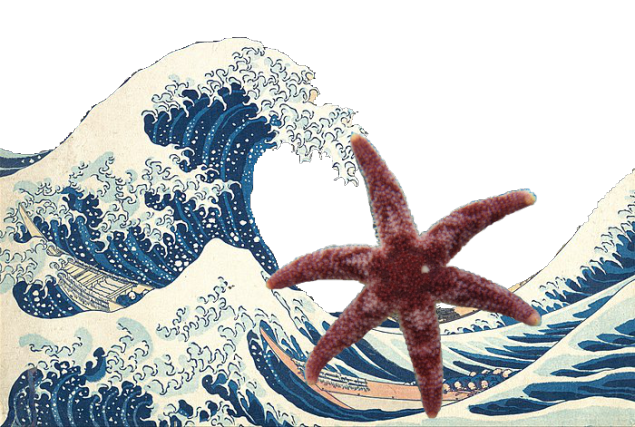

#### The newer version of netcdf4 doesnt work when pulling from NOAA's ERDAAP server, so this just installs an older version

In [1]:
pip install netcdf4==1.5.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
  Created wheel for netcdf4: filename=netCDF4-1.5.5-cp310-cp310-linux_x86_64.whl size=2753276 sha256=22d8d2fb1b5b2ab86e9e2696586941eb59541ee8f9bb4e9ab235867acb57827f
  Stored in directory: /root/.cache/pip/wheels/08/56/de/5ed3ee7ceb5a3e85fc78e51a9b7ae202cc8730ed7cb56885c5
Successfully built netcdf4


### Running some library, adds relevant packages that we will use below

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 26 13:28:20 2022

@author: jespi
"""

# load some library
import xarray as xr
import numpy as np
import os
from dateutil.parser import parse
from datetime import datetime, timedelta
import numpy.ma as ma
import subprocess
import matplotlib.pyplot as plt
import netCDF4
import sys
import matplotlib.pyplot as plt
import shutil
import warnings
warnings.filterwarnings('ignore')
import argparse
from matplotlib.dates import DateFormatter

#### Making sure have the 1.5.5 version of netcdf

In [3]:
print('netcdf4-python version: %s'%netCDF4.__version__)

netcdf4-python version: 1.5.5


## Here we are creating a dictionary to house all Cohen Lab field sites

*   Most importantly the field site coordinates which we will refer back to
*   Added site descriptions, researchers, and whats being done at each site
*   When referencing or calling a specific field site, we will use the dictionary key, so 'Amarai Point' is 'ap'


---




In [4]:
site_dict = {'ap': {'name' : 'Aramai Point',
        'lon' : -122.500725,
        'lat' : 37.607919,
        'Location' : 'Pacifica, San Mateo County, CA',
        'Site Description' : 'Aramai Point was originally named Rockaway Beach but has since been renamed to honor the Native American tribe that lived in the area for thousands of years. This public beach has hiking trails leading to prominent headlands that overshadow a rocky intertidal habitat below. The intertidal zone is very accessible, beginning a few hundred yards from the parking lot. Anemones, sea stars, tunicates, barnacles, and many other inverts are found throughout this site. Aramai Point is heavily trafficed by surfers, fishermen, and families, especially on the weekends.',
        'Research Conducted' : 'Identifying the impact intertidal positioning has on the symbiotic relationship between Anthopleura sola and their algal photosynthesizers.',
        'Student Researchers' : 'Jesse Espinoza'
                    },  

'mcb': {'name' : 'McClures Beach',
        'lon' : -122.96559,
        'lat' : 38.18253,
        'location' : 'Point Reyes National Seashore, CA',
        'Site Description' : 'Access to an area of large rocky cobble via a long, wide sandy beach. Beach is reached by an easy half mile hike on a maintained trail. Dense and diverse native community, including very abundant Pisaster sea stars.', 
        'Research Conducted' : 'Water temperature monitoring, sea star population monitoring. Salinity and temperature changes of interest in assessing sea star recovery from wasting disease.',
        'Student Researchers' : 'Meredyth Duncan; citizen science researchers Carol Hunt and Beth Schriock'
                    },
         
'mir': {'name' : 'Mile Rock',
        'lon' : -122.50954,
        'lat' : 37.78557,
        'Location' : 'GGNRA, San Francisco, CA',
        'Site Description' : 'Steep hike down maintained park trails to a popular public beach. Beach consists of an area of large boulders, a section of sandy beach, and a large rock stack surrounded by smaller cobble. Very high wave action. Community dominated by wave-tolerant species like mussels and barnacles. Low intertidal communities generally not accessible, only high- and mid-intertidal.', 
        'Research Conducted' : 'Water temperature monitoring, monitoring of invasive Watersipora spp. Data is being gathered on the impact of salinity and temperature on the persistence and species population dynamics of W. spp.',
        'Student Researchers' : 'Meredyth Duncan, Jesse Espinoza'
                    },
 
'mb': {'name' : 'Muir Beach',
        'lon' : -122.58054,
        'lat' : 37.85893,
        'Location' : 'GGNRA, Marin County, CA',
        'Site Description' : 'Popular public beach accessed by a short walk. Beach is very wide and sandy, bracketed by two areas of boulders and cobble. Cobble zones colonized by typical native assemblages. The small north cobble zone is extensively colonized by W. spp.; W. spp. also present in the larger southern boulder/cobble zone, but at dramatically lower abundances.', 
        'Research Conducted' : 'Water temperature monitoring, monitoring of invasive Watersipora spp. Data is being gathered on the impact of salinity and temperature on the persistence and species population dynamics of W. spp.',
        'Student Researchers' : 'Meredyth Duncan, Nicole Cristales'
                    },

'mub': {'name' : 'Mussel Beach',
         'lon' : -122.49615,
         'lat' : 37.6663,
         'location' : 'Daly City, San Mateo County, CA',
         'Site Description' : 'Very small, protected cove with a small sandy beach, accessed by a hike down switchback gravel trails. High wave action. Mussels extremely abundant; significant populations gooseneck barnacles and Pisaster sea stars. Leptasterias sea stars were previously very abundant, but have not been observed since the wasting disease population crash.',
         'Research Conducted' : 'Water temperature monitoring, sea star population monitoring. Salinity and temperature changes of interest in assessing sea star recovery from wasting disease.',
         'Student Researchers' : 'Meredyth Duncan, Cassie Vaniotis'
                    },
 
'pp': {'name' : 'Pigeon Point',
        'lon' : -122.396642,
        'lat' : 37.185969,
        'Location' : 'San Mateo County, CA',
        'Site Description' : '', 
        'Research Conducted' : '',
        'Student Researchers' : 'Michelle Kelly, Cassie Vaniotis'
                    },
 
'pb': {'name' : 'Point Bonita Lighthouse',
        'lon' : -122.52947,
        'lat' : 37.81872,
        'Location' : 'GGNRA, Marin County, CA',
        'Site Description' : 'Restricted access down a steep eroding cliff to a protected beach area facing the Bay. A sandy beach broken by large rocky promontories transitions to a narrow area of low rocky cobble well-colonized by algae and anemones. Site receives significantly less wave impact than the west side of Point Bonita.', 
        'Research Conducted' : 'Water temperature monitoring, monitoring of invasive Watersipora spp. and Didemnum vexillum. Data is being gathered on the impact of salinity and temperature on the persistence and species population dynamics of W. spp. and D. vex.',
        'Student Researchers' : 'Meredyth Duncan, Nicole Cristales'
                    }, 
        
'sr': {'name' : 'Slide Ranch',
         'lon' : -122.59838,
         'lat' : 37.87224,
         'location' : 'GGNRA, Marin County, CA',
         'Site Description' : 'Relatively steep hike down a brush-covered hill, leading to an extremely rugged stretch of rocky cliff coastline characterized by large boulder beds and cobble, rocky promontories, and small stretches of sandy/pebble beach. Study site is a wide area of large cobble and boulders surrounding a large protected tidepool. Upper intertidal is dominated by turban snails, mussels, and barnacles on otherwise-bare rock, while the lower intertidal is a very dense and diverse community of native species. Significant populations of Pisaster and Henricia sea stars.',
         'Research Conducted' : 'Water temperature monitoring, monitoring of invasive Watersipora spp. Data is being gathered on the impact of salinity and temperature on the persistence and species population dynamics of W. spp.',
         'Student Researchers' : 'Meredyth Duncan, Nicole Cristales'
                    }
                    }


## Create a list of all the station keys

* We can then modify our stations all at once with stns as you'll see below


---



In [5]:
stns = list(site_dict.keys())
print('Cohen field station keys:', stns)

Cohen field station keys: ['ap', 'mcb', 'mir', 'mb', 'mub', 'pp', 'pb', 'sr']


# Create lists of all lat and lon values

* Make empty lists that hold desired values
* Make a loop that goes through each station and holds its coordinate values


---



In [6]:
lats = []
lons = []
for stn in stns:
    lats.append(site_dict[stn]['lat']) #Filling up the latitude list by looping through our list of stations
    lons.append(site_dict[stn]['lon']) #Same but for longitude
    
print(lats)
print(lons)

[37.607919, 38.18253, 37.78557, 37.85893, 37.6663, 37.185969, 37.81872, 37.87224]
[-122.500725, -122.96559, -122.50954, -122.58054, -122.49615, -122.396642, -122.52947, -122.59838]


## Find the min, max, range for Cohen field sites lat and lon

* We will use these values to map the Cohen Lab field site range in a bit
---

In [7]:
lat_max = max(lats)
lat_min = min(lats)
lat_range = lat_max - lat_min

print('Latitude min and max:', lat_min, 'to', lat_max)
print('Latitude range:', lat_range)
print('')

lon_max = max(lons)
lon_min = min(lons)
lon_range = lon_max - lon_min
print('Longitude min and max:', lon_min, 'to', lon_max)
print('Longitude range:', lon_range)




Latitude min and max: 37.185969 to 38.18253
Latitude range: 0.9965609999999998

Longitude min and max: -122.96559 to -122.396642
Longitude range: 0.568948000000006


## Set the time range! You can adjust the time range!

* array datasets like the following time format, yyyy-mm-ddT00:00:00
---

In [8]:
start_time = '2022-07-01T12:00:00'
end_time = '2022-12-30T12:00:00'

## Making variables to hold the URL's we are pointing at

---



In [9]:
mur_anom_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41anom1day'
mur_sst_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41'

mur_anom_month_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41anommday'
mur_sst_month__url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41mday'

# In case someone wants to look at upwelling data
upwell_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdQBstress3day_LonPM180'

## Open a pointer to open the dataset

* These new variables will hold all the data for that link
* We'll run one below so you can see what it looks like
---

In [10]:
sst_anom = xr.open_dataset(mur_anom_url)
sst = xr.open_dataset(mur_sst_url)

month_sst_anom = xr.open_dataset(mur_anom_month_url)
month_sst = xr.open_dataset(mur_sst_month__url)

## Running sst variable

Returns the metadata which lets you know the dimensions and coordinates:
* Number of time values and range
* Latitude and Longitude values and range

Also shows the variables are in this dataset:
* analysed sst
* analysis error
* mast
* sea ice fraction

---

In [11]:
sst

<xarray.Dataset>
Dimensions:           (time: 7649, latitude: 17999, longitude: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2023-05-1...
  * latitude          (latitude) float32 -89.99 -89.98 -89.97 ... 89.98 89.99
  * longitude         (longitude) float32 -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, latitude, longitude) float64 ...
    analysis_error    (time, latitude, longitude) float64 ...
    mask              (time, latitude, longitude) float32 ...
    sea_ice_fraction  (time, latitude, longitude) float64 ...
Attributes: (12/50)
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2023-05-14T09:00:00Z
    time_coverage_start:        2002-06-01T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -179.99

# So now lets map out our field sites

### Subset the dataset to get the lat and lon region and the time period of interest 

* we are using the min and max values from the dictionary to get the whole region for all of the sites

* look at the data variables in the array from the cell above to select the
data you're interested in, in this case its analysed sst as found in the data variables from the metadata

---

In [12]:
our_sst = sst['analysed_sst'].sel(  
                      latitude=slice(lat_min, lat_max),  
                      longitude=slice(lon_min, lon_max),  
                      time=slice(start_time, end_time)  
                      )

## Viewing the data array to see what our filtered data looks like

*   if working properly it will return the number of days specified in your entered time ranges

---

In [13]:
our_sst

<xarray.DataArray 'analysed_sst' (time: 181, latitude: 100, longitude: 57)>
[1031700 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2022-07-02T09:00:00 ... 2022-12-30T09:00:00
  * latitude   (latitude) float32 37.19 37.2 37.21 37.22 ... 38.16 38.17 38.18
  * longitude  (longitude) float32 -123.0 -122.9 -122.9 ... -122.4 -122.4 -122.4
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          "Final" version using Multi-Resolution Variational Anal...
    ioos_category:    Temperature
    long_name:        Analysed Sea Surface Temperature
    source:           MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G-NAVO,...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        57.767
    valid_min:        -7.767000000000003

# Mapping all field sites
* time = # will be the fifth time interval in our date range

---

Cohen Field Site Map


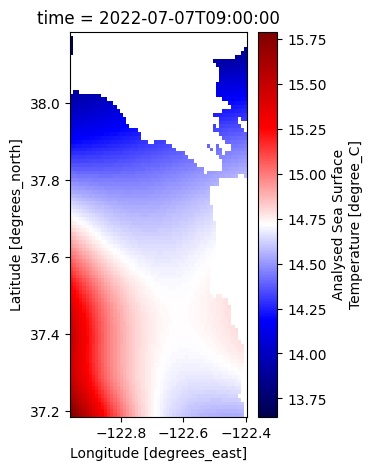

In [14]:
print('Cohen Field Site Map')
our_sst.isel(time=5).plot.imshow(cmap='seismic', aspect=lon_range/lat_range, size=5)

## Plot the sst values for the whole research area
* Gives us the average temperature value from our research area per day in our time range

---

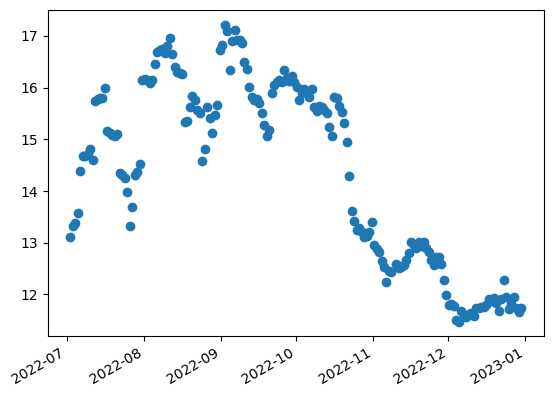

In [15]:
plt.plot(our_sst.time, our_sst.mean(axis=(1,2)), 'o')

plt.gcf().autofmt_xdate() # auto format the date label position on the x axis

# So now we can map and plot sst with specific sites only.

*   first we need to adjust the coordinates a bit so they go a few km off the coast, results would be skewed or unavailable if land is in the coordinates
*   we'll also make a sample area for each site that is roughly 5x5km
*   the same adjustment appears to work for each site, so below is a function that will make these sample areas for each site



---

In [16]:
def site_sample_area(site): 
  '''
  This function will take your sites coordinates and make the sample area while 
  scooting a bit away from land. Then it will take those coordinates and apply
  them to a pointer (in this case sst), which has the variable selected and 
  our time range in too.

  To do other pointers, this code can be expanded, or duplicated but for other
  variables

  site = dictionary site key, an abbreviation in quotation marks. Ex: 'ap'
  '''
  site_lon = site_dict[site]['lon']
  site_lon_min = site_lon - 2 * 0.04
  site_lon_max = site_lon - 0.04

  site_lat = site_dict[site]['lat']
  site_lat_min = site_lat - 2 * 0.04
  site_lat_max = site_lat - 0.04
  
  print('lon:', site_lon_min, site_lon_max) #uncomment if you want to see the coordinates per your site
  print('lat:', site_lat_min, site_lat_max)

  your_sst =sst['analysed_sst'].sel(  
                    latitude=slice(site_lat_min, site_lat_max),  
                    longitude=slice(site_lon_min, site_lon_max),  
                    time=slice(start_time, end_time)  
                    )

  return your_sst
    

## Testing our function with Muir Beach

*   here we have the metadata showing how many time points we have and the lat
and lon ranges
---

In [17]:
mb_beach = site_sample_area('mub')
mb_beach

lon: -122.57615 -122.53615
lat: 37.5863 37.6263


<xarray.DataArray 'analysed_sst' (time: 181, latitude: 4, longitude: 4)>
[2896 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2022-07-02T09:00:00 ... 2022-12-30T09:00:00
  * latitude   (latitude) float32 37.59 37.6 37.61 37.62
  * longitude  (longitude) float32 -122.6 -122.6 -122.6 -122.5
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          "Final" version using Multi-Resolution Variational Anal...
    ioos_category:    Temperature
    long_name:        Analysed Sea Surface Temperature
    source:           MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G-NAVO,...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        57.767
    valid_min:        -7.767000000000003

## Map it as we did with all the Cohen field sites



---



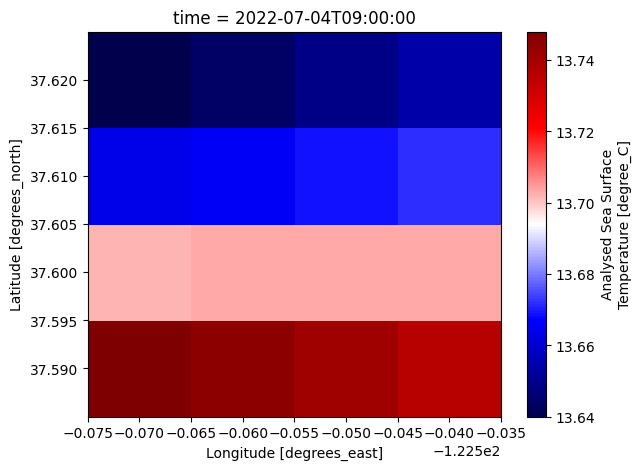

In [18]:
mb_beach.isel(time=2).plot.imshow(cmap='seismic', size=5)

# Plot it!

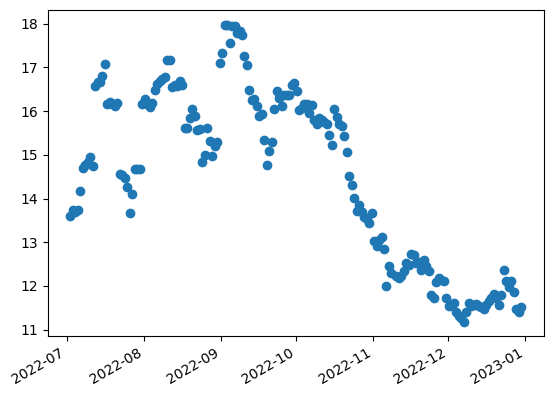

In [19]:
plt.plot_date(mb_beach.time, mb_beach.mean(axis=(1,2)), 'o')
plt.gcf().autofmt_xdate()

## Running the function for all sites
---



In [20]:
ap_beach = site_sample_area('ap')
mub_beach = site_sample_area('mub')
sr_beach = site_sample_area('sr')
mir_beach = site_sample_area('mir')
pp_beach = site_sample_area('pp')
pb_beach = site_sample_area('pb')
mcb_beach = site_sample_area('mcb')
mb_beach = site_sample_area('mb')

lon: -122.580725 -122.54072500000001
lat: 37.527919000000004 37.567919
lon: -122.57615 -122.53615
lat: 37.5863 37.6263
lon: -122.67838 -122.63838000000001
lat: 37.79224 37.83224
lon: -122.58954 -122.54954000000001
lat: 37.70557 37.74557
lon: -122.476642 -122.436642
lat: 37.105969 37.145969
lon: -122.60947 -122.56947000000001
lat: 37.73872 37.77872
lon: -123.04559 -123.00559000000001
lat: 38.10253 38.14253
lon: -122.66054 -122.62054
lat: 37.77893 37.81893


# Now we can map and plot any of these sites by repeating the code we used for Muir Beach!

---



# Here's an example of another field site with some information added to the axes
* using the Matplotlib visualization package to change aesthetics

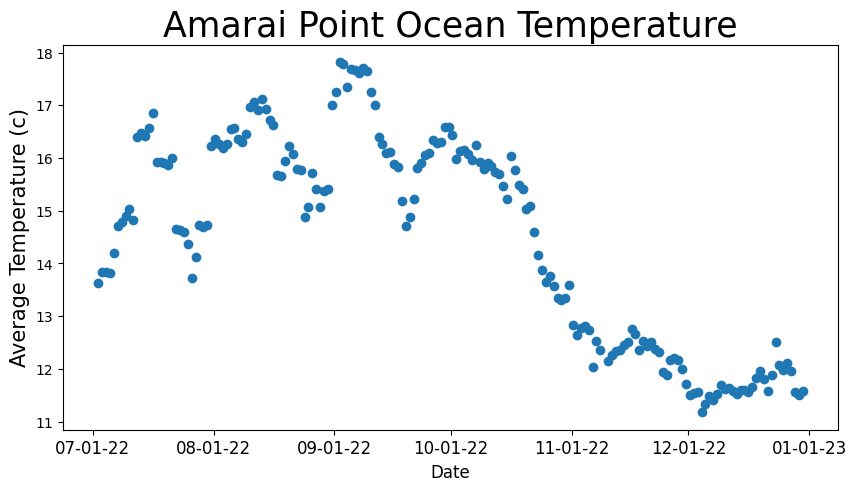

In [21]:
f, (ax) = plt.subplots(figsize=(10,5))

ax.plot(ap_beach.time, ap_beach.mean(axis=(1,2)), 'o')
ax.set(xlabel= 'Date', ylabel='Average Temperature (c)')
ax.set_title('Amarai Point Ocean Temperature', fontsize =25)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize=12, labelbottom=True)
ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%y"))

# Lastly, here's a graph comparing a southern and northern Cohen sites together.

Few ideas:
*   you can make loops that run through all sites and plot them on the same or different graphs
*   get the numerical data and analyze it statistically

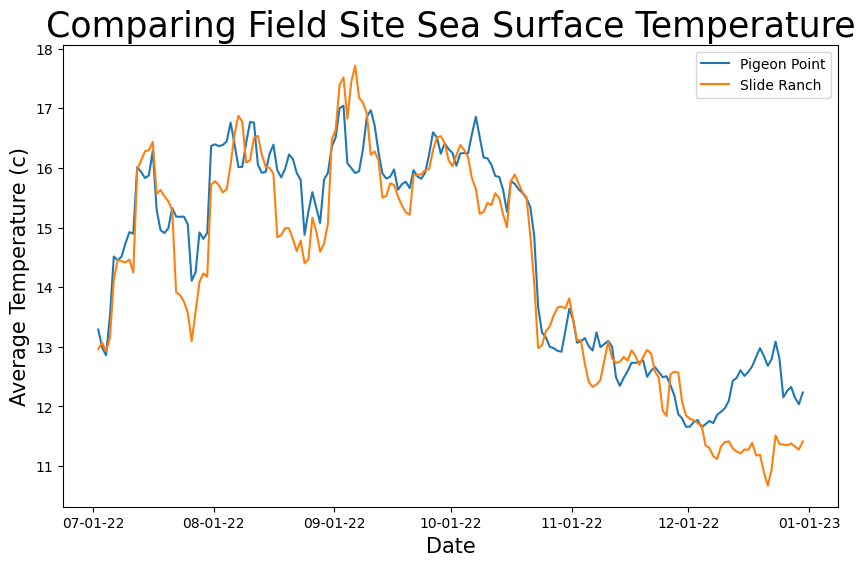

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pp_beach.time, pp_beach.mean(axis=(1,2)), label = 'Pigeon Point')
ax.plot(sr_beach.time, sr_beach.mean(axis=(1,2)), label = 'Slide Ranch')
ax.set(xlabel = 'Date', ylabel = 'Average Temperature (c)')
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
ax.set_title('Comparing Field Site Sea Surface Temperature', fontsize =25)
ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%y"))

ax.legend(loc="best")